<a href="https://colab.research.google.com/github/shouvikpal8991/assignment-4/blob/main/Assig4pr10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install emcee
!pip install corner

In [21]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import requests

# Step 1: Download and read the data
url = "https://theory.tifr.res.in/~kulkarni/data.txt"
response = requests.get(url)

# Read the data line by line, skipping the header
lines = response.iter_lines()
next(lines)  # Skip the header

# Initialize empty lists to store the data
x_data = []
y_data = []
yerr_data = []

# Read the data line by line
for line in lines:
    parts = line.decode('utf-8').split('\t')  # Split by tabs
    if len(parts) >= 4:  # Check if there are enough columns
        x_data.append(float(parts[1]))  # Column 2: x
        y_data.append(float(parts[2]))  # Column 3: y
        yerr_data.append(float(parts[3]))  # Column 4: sigma

# Convert lists to numpy arrays
x = np.array(x_data)
y = np.array(y_data)
yerr = np.array(yerr_data)

# Rest of the code remains the same...







# Define the model: y = a*x^2 + b*x + c
def model(theta, x):
    a, b, c = theta
    return a * x**2 + b * x + c

# Define the log likelihood function
def log_likelihood(theta, x, y, sigma):
    model_y = model(theta, x)
    return -0.5 * np.sum((((y - model_y) / sigma) ** 2) + (np.log(2 * np.pi * sigma**2)))

# Define the log prior function
def log_prior(theta):
    a, b, c = theta
    if -1000 < a < 1000 and -1000 < b < 1000 and -1000 < c < 1000:
        return 0.0
    return -np.inf

# Define the log probability function
def log_probability(theta, x, y, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma)


# Set up the MCMC sampler
nwalkers = 50
ndim = 3
nsteps = 4000
guess = [1.0, 1.0, 1.0]
pos = guess + 1e-4 * np.random.randn(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))


# Run the MCMC chains
sampler.run_mcmc(pos, nsteps)

# Get the samples
samples = sampler.get_chain(discard=100, thin=15, flat=True)
#print("Shape of samples:", samples.shape)


# Compute the quantiles
quantiles = np.percentile(samples, [16, 50, 84], axis=0)
medians = quantiles[1]
one_sigma = np.diff(quantiles, axis=0)

# Results
print("Best-fit values (medians):", medians)
print("\n One-sigma uncertainties:", one_sigma)

Best-fit values (medians): [-7.81169895e-03  3.71831224e+00  1.86759175e+01]

 One-sigma uncertainties: [[8.90101073e-04 3.26926909e-01 2.62189499e+01]
 [9.44032647e-04 3.09330988e-01 2.72368444e+01]]


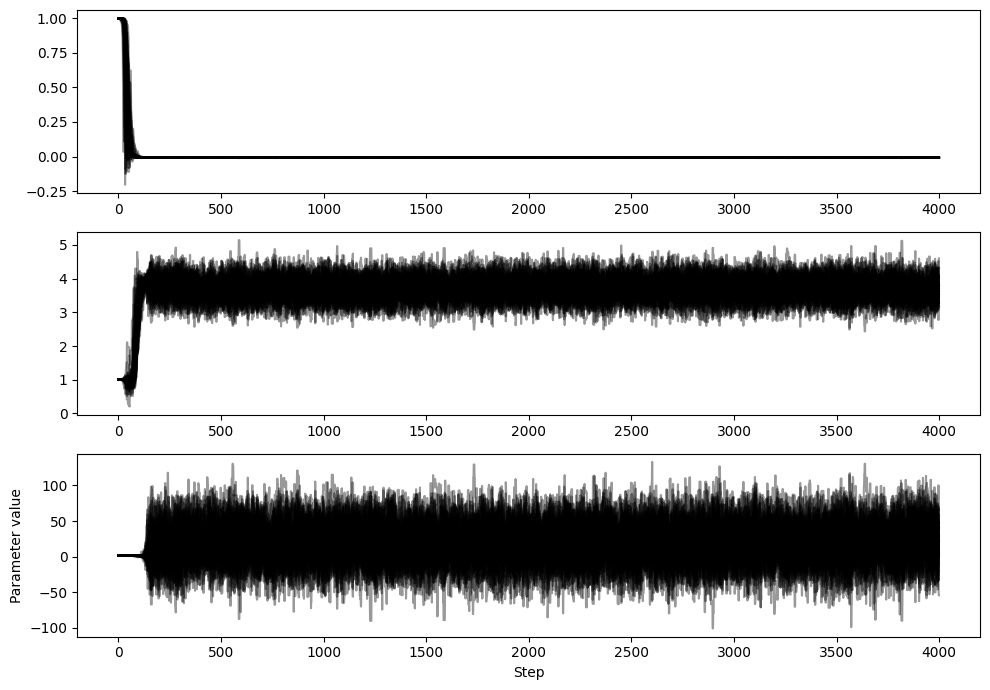

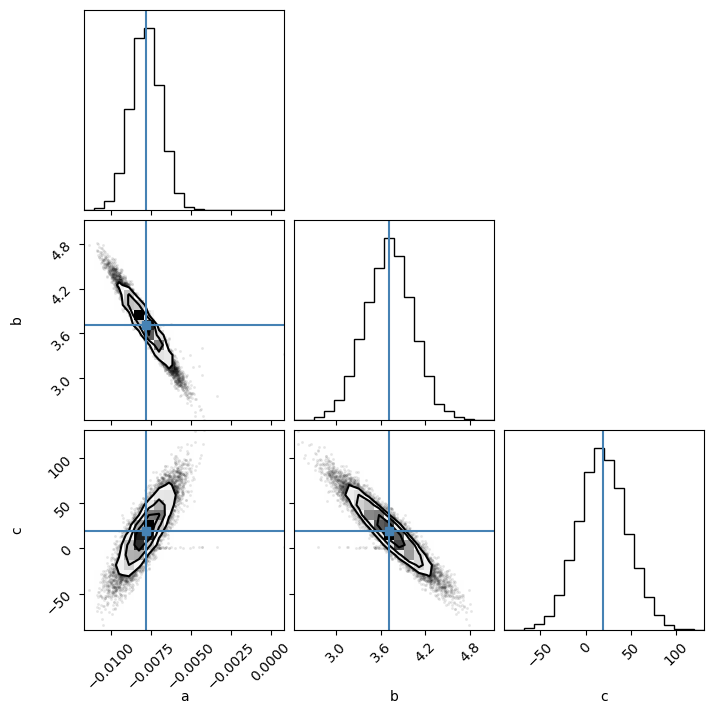

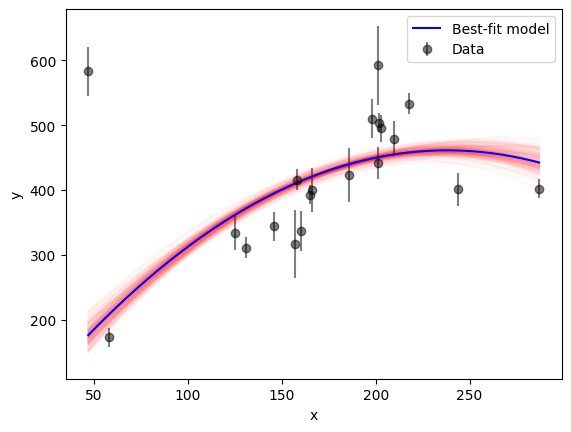

In [23]:
# Plot the chains
plt.figure(figsize=(10, 7))
for i in range(ndim):
    plt.subplot(ndim, 1, i + 1)
    plt.plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
plt.xlabel("Step")
plt.ylabel("Parameter value")
plt.tight_layout()
plt.show()

# Plot the posterior PDFs
labels = ["a", "b", "c"]
fig = corner.corner(samples, labels=labels, truths=medians)
plt.show()

# Plot the data with the best-fit model and 200 randomly chosen models
plt.errorbar(x, y, yerr=yerr, fmt="o", label="Data", color="k", alpha=0.5)

x_range = np.linspace(min(x), max(x), 100)
for params in samples[np.random.randint(len(samples), size=200)]:
    plt.plot(x_range, model(params, x_range), color="r", alpha=0.02)

plt.plot(x_range, model(medians, x_range), color="b", label="Best-fit model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
